# Supervised Learning Project - Bank Customer Exit Analysis

## Initialization

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, \
                            precision_recall_curve, roc_curve, roc_auc_score, f1_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Pre-processing

### Cleaning

In [5]:
# Drop Unique Identifier Columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [6]:
# Examine Missing values
df[df['Tenure'].isna()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [7]:
# Check if Tenure has outliers - decide Ither to fill NaNs with mean or median value
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
# Fill missing Tenure values with mean value since there are no major outliers (mean almost equals median)
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].mean())

### Feature preparation

In [9]:
# OHE to transform categorical features
df_ohe = pd.get_dummies(df, drop_first=True)

### Extract & split training and validation sets

In [10]:
features = df_ohe.drop(['Exited'], axis = 1)
target = df_ohe['Exited']

In [11]:
# Since the test set doesn't exist, first split into test (20%) & training (80%) sets
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [12]:
# Then split the training into validation (20%) & training (60%) sets.
# Use 25% for the validation size to make sure it equals the test size
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=0)

In [13]:
# Check the size of the resulting features to make sure they follow the 3:1:1 rule
print('Training:', features_train.shape, round(len(features_train)/len(df),2))
print('Validation:', features_valid.shape, round(len(features_valid)/len(df),2))
print('Test:', features_test.shape, round(len(features_test)/len(df),2))
print('df:', df.shape)

Training: (6000, 11) 0.6
Validation: (2000, 11) 0.2
Test: (2000, 11) 0.2
df: (10000, 11)


### Feature scaling

In [14]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5228,751,29,10.0,147737.63,1,0,1,94951.27,0,0,1
4144,655,44,8.0,87471.63,1,0,1,188593.98,0,0,1
1939,739,37,7.0,104960.46,1,0,1,80883.82,0,0,1
8994,612,43,4.0,139496.35,2,1,1,77128.23,0,0,0
4048,602,63,7.0,0.00,2,1,1,56323.21,0,0,0


In [15]:
pd.options.mode.chained_assignment = None #silence errors

#select numeric columns to standardize
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


In [16]:
# Check that the numeric columns Ire standardized
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5228,1.037413,-0.932794,1.825380,1.148175,-0.893918,0,1,-0.094434,0,0,1
4144,0.046343,0.484084,1.094505,0.184194,-0.893918,0,1,1.527070,0,0,1
1939,0.913530,-0.177126,0.729068,0.463935,-0.893918,0,1,-0.338024,0,0,1
8994,-0.397574,0.389626,-0.367244,1.016352,0.831237,1,1,-0.403055,0,0,0
4048,-0.500811,2.278797,0.729068,-1.214954,0.831237,1,1,-0.763311,0,0,0


### Class balance

In [17]:
target_train.value_counts(normalize=True)

0    0.7995
1    0.2005
Name: Exited, dtype: float64

**Conclusions**

- All categorical features were transformed using one-hot encoding.
- Training, validation and test data were split 3:1:1.
- All numeric columns were standardized to be on the same scale.
- Investigate class balance
    - The target training classes are far from a 1:1 ratio, so they are imbalanced. There are more negative than positive classes (about 4:1).

## Initial ML Models (Imbalanced data)
I will compare the performance metrics of 3 models using the imbalanced training data.

### Decision Tree Classification (Imbalanced)

In [18]:
# Initialize and train model
model = DecisionTreeClassifier(random_state=0)
model.fit(features_train, target_train)

# Get model predictions on validation set
predicted_valid = model.predict(features_valid)

# Get model probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

In [19]:
# Classification metrics on validation set
print(f'F1 score: {f1_score(target_valid, predicted_valid):.2f}')
print(f'AUC-ROC score: {roc_auc_score(target_valid, probabilities_one_valid):.2f}')
print()

# Confusion Matrix
print(confusion_matrix(target_valid, predicted_valid))
print()

# Precision & Recall
print(f'Recall: {recall_score(target_valid, predicted_valid):.2f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.2f}')

F1 score: 0.50
AUC-ROC score: 0.69

[[1366  227]
 [ 195  212]]

Recall: 0.52
Precision: 0.48


**Decision Tree (Imbalanced Classification) Conclusions:**
- F1 score on the validation set is 0.50.
- AUC_ROC score is 0.69.
- There are 195 false negative and 227 false positive predictions by the model.
- Recall (0.52) is slightly higher than precision (0.48).

### Random Forest Classification (Imbalanced)

In [20]:
# Initialize and train model
model = RandomForestClassifier(random_state=0)
model.fit(features_train, target_train)

# Get model predictions on validation set
predicted_valid = model.predict(features_valid)

# Get model probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

In [21]:
# Classification metrics on validation set
print(f'F1 score: {f1_score(target_valid, predicted_valid):.2f}')
print(f'AUC-ROC score: {roc_auc_score(target_valid, probabilities_one_valid):.2f}')
print()

# Confusion Matrix
print(confusion_matrix(target_valid, predicted_valid))
print()

# Precision & Recall
print(f'Recall: {recall_score(target_valid, predicted_valid):.2f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.2f}')

F1 score: 0.60
AUC-ROC score: 0.86

[[1540   53]
 [ 211  196]]

Recall: 0.48
Precision: 0.79


**Random Forest (Imbalanced Classification) Conclusions:**
- F1 score on the validation set is 0.60.
- AUC_ROC score is 0.86.
- There are 211 false negative and 53 false positive predictions by the model.
- Precision (0.79) is higher than recall (0.48).

### Logistic Regression (Imbalanced)

In [22]:
# Initialize and train model
model = LogisticRegression(random_state=0, solver='liblinear')
model.fit(features_train, target_train)

# Get model predictions on validation set
predicted_valid = model.predict(features_valid)

# Get model probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

In [23]:
# Classification metrics on validation set
print(f'F1 score: {f1_score(target_valid, predicted_valid):.2f}')
print(f'AUC-ROC score: {roc_auc_score(target_valid, probabilities_one_valid):.2f}')
print()

# Confusion Matrix
print(confusion_matrix(target_valid, predicted_valid))
print()

# Precision & Recall
print(f'Recall: {recall_score(target_valid, predicted_valid):.2f}')
print(f'Precision: {precision_score(target_valid, predicted_valid):.2f}')

F1 score: 0.28
AUC-ROC score: 0.78

[[1544   49]
 [ 332   75]]

Recall: 0.18
Precision: 0.60


**Logistic Regression (Imbalanced Classification) Conclusions:**
- F1 score on the validation set is low at 0.28.
- AUC_ROC score is 0.78.
- There are 332 false negative and 49 false positive predictions by the model.
- Precision (0.60) is higher than recall (0.18) - the model is better at identifying negative answers.

**Overall Conclusions:**
- Random Forest has the best F1 score at 0.60.
- Random Forest has the best AUC_ROC score at 0.86.
- Logistic Regression has the fewest false positive predictions (49).
- Decision Tree has the fewest false negative predictions (195).
- Decision Tree and Random Forest have the best recall (.52 and .48), respectively.
- Random Forest has the best precision 0.79.

## Upsampling
Since I determined that the classes are imbalanced, I will perform upsampling to make positive observations less rare in the data

In [24]:
# Create a function to use for upsampling
def upsample(features, target, repeat):
    #split data into negative and positive observations
    features_zero = features[target == 0]
    features_ones = features[target == 1]
    target_zero = target[target == 0]
    target_ones = target[target == 1]
    
    #duplicate positive observations and create new training samples
    features_upsampled = pd.concat([features_zero] + [features_ones]*repeat)
    target_upsampled = pd.concat([target_zero] + [target_ones]*repeat)
    
    #shuffle the data so identical questions don't follow eachother
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=0)
    
    return features_upsampled, target_upsampled
    

In [25]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [26]:
# Check to see if classes are balanced now
target_upsampled.value_counts(normalize=True)

1    0.500781
0    0.499219
Name: Exited, dtype: float64

**Conclusion**

- Classes are now balanced 1:1 in the training set.

## ML Model Comparisons

### Decision Tree Classifier

In [27]:
# Use upsampled training set to adjust for class imbalance

# Initialize and train the model using different hyperparameters: max_depth, min_samples_split, min_samples_leaf
upsampled_best_score = 0

for depth in range(1,11):
    for samples in range(2,11):
        for leaf in range(1,11):
            model = DecisionTreeClassifier(criterion='gini', random_state = 0, max_depth = depth, 
                                           min_samples_split = samples, min_samples_leaf = leaf)
            model.fit(features_upsampled, target_upsampled)
            # Get model predictions on the validation set
            predictions_valid = model.predict(features_valid)
            # Get model probabilities
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:,1]
            # Calculate F1 score on the validation set
            score = f1_score(target_valid, predictions_valid)
            if score > upsampled_best_score:
                upsampled_best_score = score
            # Calculate auc-roc
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

    
print('F1 score of the best Decision Tree model using upsampling:', upsampled_best_score, 'max_depth=', depth, 
      'min_samples_split=', samples, 'min_samples_leaf=', leaf)
print()
print(f'AUC-ROC Score: {auc_roc:.2f}')

F1 score of the best Decision Tree model using upsampling: 0.5724703737465816 max_depth= 10 min_samples_split= 10 min_samples_leaf= 10

AUC-ROC Score: 0.80


In [28]:
# Use class_weight = 'balanced' to adjust for class imbalance

# Initialize and train the model using different hyperparameters: max_depth, min_samples_split, min_samples_leaf
class_weight_best_score = 0

for depth in range(1,11):
    for samples in range(2,11):
        for leaf in range(1,11):
            model = DecisionTreeClassifier(criterion='gini', random_state = 0, max_depth = depth, 
                                           min_samples_split = samples, min_samples_leaf = leaf, 
                                           class_weight='balanced')
            model.fit(features_train, target_train)
            # Get model predictions on the validation set
            predictions_valid = model.predict(features_valid)
            # Get model probabilities
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:,1]
            # Calculate F1 score on the validation set
            score = f1_score(target_valid, predictions_valid)
            if score > class_weight_best_score:
                class_weight_best_score = score
            # Calculate auc-roc
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
print('F1 score of the best Decision Tree model using class_weight:', class_weight_best_score, 'max_depth=', depth, 
      'min_samples_split=', samples, 'min_samples_leaf=', leaf)
print()
print(f'AUC-ROC Score: {auc_roc:.2f}')

F1 score of the best Decision Tree model using class_weight: 0.5724703737465816 max_depth= 10 min_samples_split= 10 min_samples_leaf= 10

AUC-ROC Score: 0.81


In [29]:
# Compare upsampled vs. class_weight = 'balanced' methods on F1 scores, print the higher one
if upsampled_best_score == class_weight_best_score:
    print('No change in F1 score using upsampling or class_weight methods')
elif upsampled_best_score > class_weight_best_score:
    print(f'Upsampled F1 score is higher: {upsampled_best_score:.4f}')
else:
    print(f'class_weight = "balanced" F1 score is higher: {class_weight_best_score:.4f}')

No change in F1 score using upsampling or class_weight methods


### Random Forest Classifier

In [30]:
# Use upsampled training set to adjust for class imbalance

# Initialize and train the model using different hyperparameters: min_samples_split, max_depth
upsampled_best_score = 0

for samples in range(2,11):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 0, min_samples_split=samples, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        # Get model predictions on the validation set
        predictions_valid = model.predict(features_valid)
        # Get model probabilities
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:,1]
        # Calculate F1 score on the validation set
        score = f1_score(target_valid, predictions_valid)
        if score > upsampled_best_score:
            upsampled_best_score = score
        # Calculate auc-roc
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
print('F1 score of the best Random Forest model:', upsampled_best_score, 'max_depth=', depth, 
      'min_samples_split=', samples)
print()
print(f'AUC-ROC Score: {auc_roc:.2f}')

F1 score of the best Random Forest model: 0.6135371179039302 max_depth= 10 min_samples_split= 10

AUC-ROC Score: 0.87


In [31]:
# Use class_weight = 'balanced' to adjust for class imbalance

# Initialize and train the model using different hyperparameters: min_samples_split, max_depth
class_weight_best_score = 0

for samples in range(2,11):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 0, min_samples_split=samples, max_depth=depth, 
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        # Get model predictions on the validation set
        predictions_valid = model.predict(features_valid)
        # Get model probabilities
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:,1]
        # Calculate F1 score on the validation set
        score = f1_score(target_valid, predictions_valid)
        if score > class_weight_best_score:
            class_weight_best_score = score
        # Calculate auc-roc
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
print('F1 score of the best Random Forest model:', class_weight_best_score, 'max_depth=', depth, 
      'min_samples_split=', samples)
print()
print(f'AUC-ROC Score: {auc_roc:.2f}')

F1 score of the best Random Forest model: 0.6289752650176678 max_depth= 10 min_samples_split= 10

AUC-ROC Score: 0.87


In [32]:
# Compare upsampled vs. class_weight = 'balanced' methods on F1 scores, print the higher one
if upsampled_best_score == class_weight_best_score:
    print('No change in F1 score using upsampling or class_weight methods')
elif upsampled_best_score > class_weight_best_score:
    print(f'Upsampled F1 score is higher: {upsampled_best_score:.4f}')
else:
    print(f'class_weight = "balanced" F1 score is higher: {class_weight_best_score:.4f}')

class_weight = "balanced" F1 score is higher: 0.6290


### Logistic Regression

In [33]:
# Use upsampled training set to adjust for class imbalance

# Initialize and train the model 
model = LogisticRegression(random_state = 0, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)

# Get model predictions on the validation set
predictions_valid = model.predict(features_valid)

# Get model probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

# Calculate F1 score on the validation set
upsampled_score = f1_score(target_valid, predictions_valid)

# Calculate auc-roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
print('F1 score of the Logistic Regression model using upsampling:', upsampled_score)
print()
print(f'AUC-ROC Score: {auc_roc:.2f}')

F1 score of the Logistic Regression model using upsampling: 0.5008695652173913

AUC-ROC Score: 0.78


In [34]:
# Use class_weight = 'balanced' to adjust for class imbalance

# Initialize and train the model 
model = LogisticRegression(random_state = 0, solver = 'liblinear', class_weight='balanced')
model.fit(features_train, target_train)

# Get model predictions on the validation set
predictions_valid = model.predict(features_valid)

# Get model probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

# Calculate accuracy score on the validation set
class_weight_score = f1_score(target_valid, predictions_valid)

# Calculate auc-roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
print('F1 score of the Logistic Regression model using class_weight:', class_weight_score)
print()
print(f'AUC-ROC Score: {auc_roc:.2f}')

F1 score of the Logistic Regression model using class_weight: 0.5004359197907585

AUC-ROC Score: 0.78


In [35]:
# Compare upsampled vs. class_weight = 'balanced' methods on F1 scores, print the higher one
if upsampled_best_score == class_weight_best_score:
    print('No change in F1 score using upsampling or class_weight methods')
elif upsampled_best_score > class_weight_best_score:
    print(f'Upsampled F1 score is higher: {upsampled_best_score:.4f}')
else:
    print(f'class_weight = "balanced" F1 score is higher: {class_weight_best_score:.4f}')

class_weight = "balanced" F1 score is higher: 0.6290


**Conclusions:**
- The Random Forest using class_weight = 'balanced' has the highest F1 score of 0.63
    - AUC-ROC scores are both 0.87.
- The Decision Tree has an F1 score of 0.57 for both class balance methods.
    - AUC-ROC score is higher for class_weight = 'balanced' method at 0.81.
- The Logistic Regression has the lowest F1 score: 0.50, which was similar for both class balance methods.
    - AUC-ROC scores are both 0.78.

## Final Model Testing
I will run the Random Forest Classifier and balance the classes using the class_weight='balanced' hyperparameter since it had the highest F1 score during validation

### Random Forest Classifier

In [36]:
# Initialize and train the best model accounting for class imbalance 
model = RandomForestClassifier(random_state = 0, min_samples_split= 10, max_depth = 10, class_weight='balanced')

# Train the model on the full training set
model.fit(features_train_valid, target_train_valid)

# Get model predictions on the test set
predicted_test = model.predict(features_test)

## Final Model Classification Metrics

### Performance Metrics

In [39]:
print(f'F1 score: {f1_score(target_test, predicted_test):.2f}')

F1 score: 0.64


In [40]:
# Confusion Matrix
print(confusion_matrix(target_test, predicted_test))
print()

# Precision & Recall
print(f'Recall: {recall_score(target_test, predicted_test):.2f}')
print(f'Precision: {precision_score(target_test, predicted_test):.2f}')

[[1394  179]
 [ 144  283]]

Recall: 0.66
Precision: 0.61


**Conclusions:**
- There are 144 false negative and 179 false positive predictions by the model. There are fewer false negatives and more false positives after balancing.
- Recall (0.66) is higher than precision (0.61). Compared to the imbalanced data, recall improved and precision decreased (from 0.48 and 0.79, respectively).

### Classification Thresholds

In [41]:
# Test different classification thresholds to see how the precision/recall scores are affected
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]

for threshold in np.arange(0, 0.98, 0.02):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)
    
    print(f'Threshold:{threshold:.2f} -- Precision:{precision:.2f}, Recall:{recall:.2f}, F1 Score: {f1:.2f}')

Threshold:0.00 -- Precision:0.21, Recall:1.00, F1 Score: 0.35
Threshold:0.02 -- Precision:0.21, Recall:1.00, F1 Score: 0.35
Threshold:0.04 -- Precision:0.22, Recall:1.00, F1 Score: 0.35
Threshold:0.06 -- Precision:0.22, Recall:1.00, F1 Score: 0.37
Threshold:0.08 -- Precision:0.24, Recall:1.00, F1 Score: 0.38
Threshold:0.10 -- Precision:0.25, Recall:1.00, F1 Score: 0.40
Threshold:0.12 -- Precision:0.26, Recall:0.99, F1 Score: 0.41
Threshold:0.14 -- Precision:0.27, Recall:0.98, F1 Score: 0.43
Threshold:0.16 -- Precision:0.29, Recall:0.96, F1 Score: 0.44
Threshold:0.18 -- Precision:0.30, Recall:0.95, F1 Score: 0.45
Threshold:0.20 -- Precision:0.32, Recall:0.94, F1 Score: 0.47
Threshold:0.22 -- Precision:0.33, Recall:0.93, F1 Score: 0.49
Threshold:0.24 -- Precision:0.35, Recall:0.91, F1 Score: 0.50
Threshold:0.26 -- Precision:0.37, Recall:0.90, F1 Score: 0.53
Threshold:0.28 -- Precision:0.39, Recall:0.89, F1 Score: 0.54
Threshold:0.30 -- Precision:0.41, Recall:0.88, F1 Score: 0.56
Threshol

### PR Curve

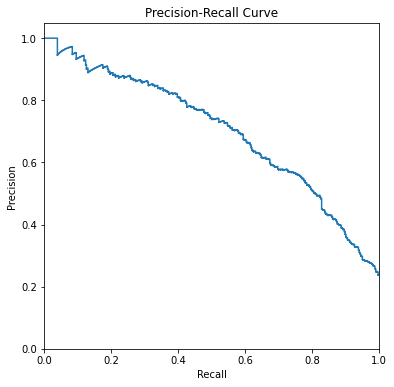

In [42]:
# Plot Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:,1])
plt.figure(figsize=(6,6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Precision-Recall Curve')
plt.show()

### ROC Curve

In [43]:
# AUC-ROC score
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'AUC-ROC Score: {auc_roc:.2f}')

AUC-ROC Score: 0.87


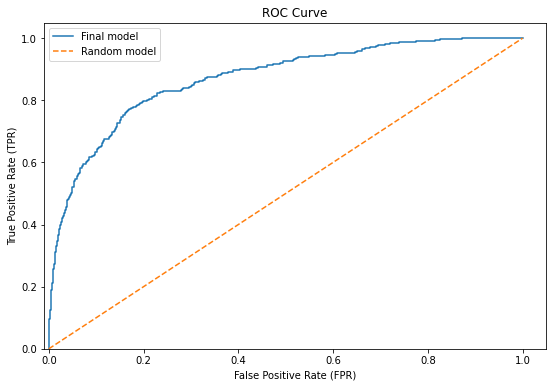

In [44]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:,1])
plt.figure(figsize=(9,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.legend(['Final model', 'Random model'])

plt.show()


** Overall Conclusions:**
- The F1 score is 0.64 which is greater than the required 0.59 threshold.
- The height of the PR Curve indicates that the final model performs well.
- The AUC-ROC score is 0.87, which means that the final model performs better than a random model.
- After balancing the classes, the F1 score increased by 0.04 and AUC-ROC increased by 0.01.